In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tqdm
import sys

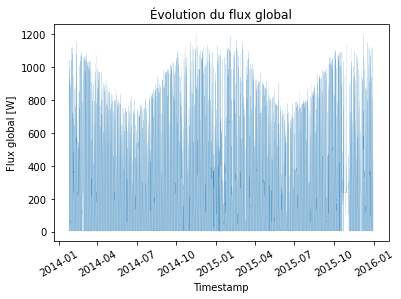

In [2]:
filepath = 'Moufia_2014_2015/moufia_2014_2015_treated.csv'
df = pd.read_csv(filepath, index_col='Timestamp')
df.index = df.index.astype('datetime64[ns]')

plt.plot(df.index, df.FG_Avg, linewidth=0.1)
plt.xticks(rotation=30)
plt.ylabel('Flux global [W]')
plt.xlabel('Timestamp')
plt.title('Évolution du flux global')
plt.show()

In [3]:
def rmse(y, yhat):
    return ((y - yhat) ** 2).mean() ** .5
def mae(y, yhat):
    return (y - yhat).abs().mean() ** .5
def r2(y, yhat):
    return 1 - ((y - yhat) ** 2).sum() / ((y - y.mean()) ** 2).sum()

### Grid serach cross validation

# Prophet

In [5]:
from sklearn.preprocessing import MinMaxScaler
from fbprophet import Prophet
df.index.name = 'ds'
df = df.reset_index(level='ds')
history = int(0.8*len(df))

In [6]:
from multiprocess import Pool
from itertools import product

def get_metrics(df, param, history):
    def rmse(y, yhat):
        return ((y - yhat) ** 2).mean() ** .5
    def mae(y, yhat):
        return (y - yhat).abs().mean() ** .5
    def r2(y, yhat):
        return 1 - ((y - yhat) ** 2).sum() / ((y - y.mean()) ** 2).sum()
    
    from sklearn.preprocessing import MinMaxScaler
    from fbprophet import Prophet
    
    default_param = {k:v for (k,v) in param.items() if k in ['growth', 'interval_width', 'weekly_seasonality']}
    df['y'] = df['FG_Avg'].rolling(window=param['window'], min_periods=1, center=True).max()

    print('Begin first model for', str(param))
    # First model
    m = Prophet(**default_param, yearly_seasonality=param['yearly_seasonality'], daily_seasonality=False)
    # Fit train data
    m.fit(df.iloc[:history])
    # Predict all data
    df_pred = m.predict(df.drop('y', axis=1))
    df['year'] = df_pred['yhat']

    df['y'] = df['FG_Avg']

    print('Begin second model for', str(param))
    # Second model
    m = Prophet(**default_param, yearly_seasonality=False, daily_seasonality=param['daily_seasonality'])
    # Fit train data
    m.fit(df.iloc[:history])
    # Predict all data
    df_pred = m.predict(df.drop('y', axis=1))
    df['day'] = df_pred['yhat']
    df['day_norm'] = MinMaxScaler().fit_transform(df['day'].values.reshape(-1, 1))
    df['seasons'] = df['day_norm']*df['year']

    print('Begin third model for', str(param))
    # Third model
    m = Prophet(**default_param, yearly_seasonality=False, daily_seasonality=False)
    m.add_regressor('seasons')
    for col in ['FD_Avg', 'RH_Avg', 'Text_Avg', 'WD_MeanUnitVector', 'WS_Mean']:
        m.add_regressor(col)
    # Fit train data
    m.fit(df.iloc[:history])
    # Predict all data
    df_pred = m.predict(df.drop('y', axis=1))
    df['yhat'] = df['day_norm']*df_pred['yhat'].clip(lower=0)

    print('End for', str(param))
    return {'rmse':rmse(df.y, df.yhat), 'mae':mae(df.y, df.yhat), 'r2':r2(df.y, df.yhat), 'param':param}

param_grid = dict(
    growth=['flat'],
    interval_width=[0.95],
    weekly_seasonality=[False],
    daily_seasonality=[50, 30, 20],
    yearly_seasonality=[5, 10],
    window=[24])

param_list = [dict(zip(param_grid.keys(), v)) for v in product(*param_grid.values())]
df_metrics = pd.DataFrame(columns=['rmse', 'mae', 'r2', 'param'])
list_metrics = Pool().starmap(get_metrics, ((df, param, history) for param in param_list) )
df_metrics = pd.DataFrame.from_records(list_metrics).sort_values(['rmse'])
df_metrics.head()

,rmse,mae,r2,param
1,145.917640,9.232688,0.745803,"{'growth': 'flat', 'interval_width': 0.95, 'we..."
3,145.917689,9.232690,0.745803,"{'growth': 'flat', 'interval_width': 0.95, 'we..."
5,145.917812,9.232693,0.745803,"{'growth': 'flat', 'interval_width': 0.95, 'we..."
0,146.018906,9.235546,0.745450,"{'growth': 'flat', 'interval_width': 0.95, 'we..."
2,146.018951,9.235547,0.745450,"{'growth': 'flat', 'interval_width': 0.95, 'we..."


### Test

In [7]:
param = dict(
    growth='flat',
    interval_width=0.95,
    weekly_seasonality=False,
    daily_seasonality=30,
    yearly_seasonality=5,
    window=24)

default_param = {k:v for (k,v) in param.items() if k in ['growth', 'interval_width', 'weekly_seasonality']}

In [8]:
df['y'] = df['FG_Avg'].rolling(window=param['window'], min_periods=1, center=True).max()

# First model
m = Prophet(**default_param, yearly_seasonality=param['yearly_seasonality'], daily_seasonality=False)

# Fit train data
m.fit(df.iloc[:history])

# Predict all data
df_pred = m.predict(df.drop('y', axis=1))
df['year'] = df_pred['yhat']

In [9]:
df['y'] = df['FG_Avg']

# Second model
m = Prophet(**default_param, yearly_seasonality=False, daily_seasonality=param['daily_seasonality'])

# Fit train data
m.fit(df.iloc[:history])

# Predict all data
df_pred = m.predict(df.drop('y', axis=1))
df['day'] = df_pred['yhat']
df['day_norm'] = MinMaxScaler().fit_transform(df['day'].values.reshape(-1, 1))
df['seasons'] = df['day_norm']*df['year']

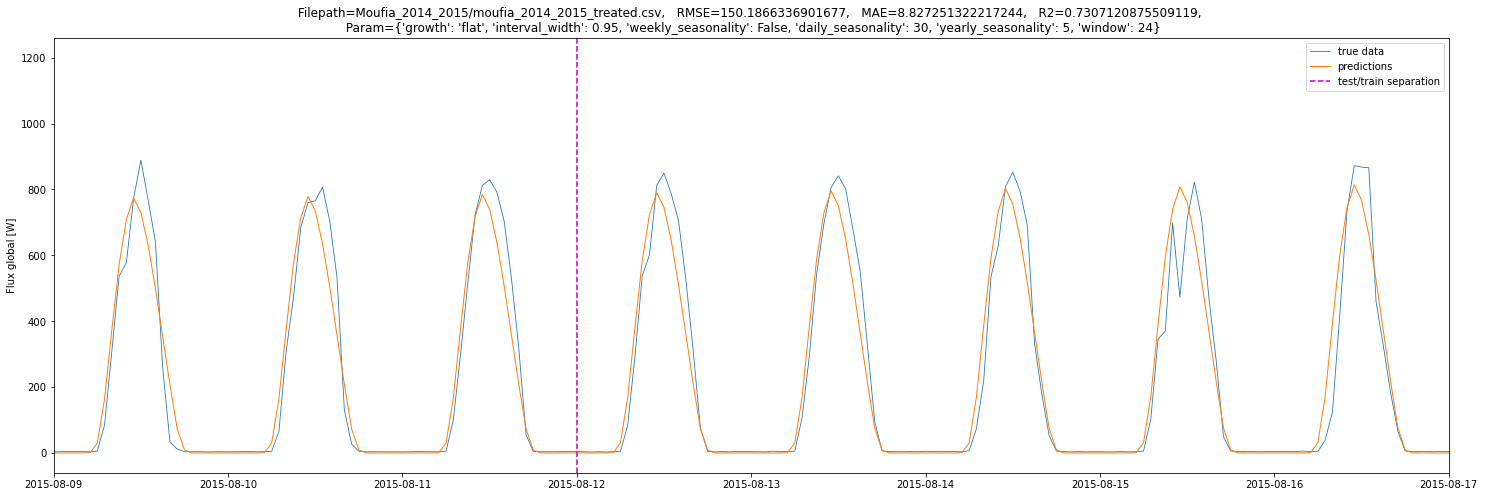

In [10]:
plt.figure(figsize=(25,8))
plt.title(f'Filepath={filepath},   RMSE={rmse(df.y, df.seasons)},   MAE={mae(df.y, df.seasons)},   R2={r2(df.y, df.seasons)}, \n Param={param}')
plt.plot(df.ds, df.y, label='true data', linewidth=0.8)
plt.plot(df.ds, df.seasons, label='predictions', linewidth=1)
plt.axvline(x=df['ds'][history], c='m', linestyle='--', label='test/train separation')
plt.ylabel('Flux global [W]')
plt.xlim(['2015-08-09', '2015-08-17'])
plt.legend()

In [ ]:
# Third model
m = Prophet(**default_param, yearly_seasonality=False, daily_seasonality=False)
m.add_regressor('seasons')
for col in ['FD_Avg', 'RH_Avg', 'Text_Avg', 'WD_MeanUnitVector', 'WS_Mean']:
    m.add_regressor(col)

# Fit train data
m.fit(df.iloc[:history])

# Predict all data
df_pred = m.predict(df.drop('y', axis=1))
df['yhat'] = df['day_norm']*df_pred['yhat'].clip(lower=0)
df['yhat_lower'] = df['day_norm']*df_pred['yhat_lower'].clip(lower=0)
df['yhat_upper'] = df['day_norm']*df_pred['yhat_upper'].clip(lower=0)

In [ ]:
plt.figure(figsize=(25,8))
plt.title(f'Filepath={filepath},   RMSE={rmse(df.y, df.yhat)},   MAE={mae(df.y, df.yhat)},   R2={r2(df.y, df.yhat)}, \n Param={param}')
plt.plot(df.ds, df.y, label='true data', linewidth=0.8)
plt.plot(df.ds, df.yhat, label='predictions', linewidth=0.5)
plt.plot(df.ds, df.yhat_lower, label='predictions lower and upper', c='c', linewidth=0.2)
plt.plot(df.ds, df.yhat_upper, c='c', linewidth=0.2)
plt.axvline(x=df['ds'][history], c='m', linestyle='--', label='test/train separation')
plt.ylabel('Flux global [W]')
plt.xlim(['2015-08-09', '2015-08-17'])
plt.legend()